# Aeon Preprocessing for Formula 1 Time Series Data

This notebook demonstrates how to apply aeon-toolkit preprocessing techniques to Formula 1 time series data. The F1 data is processed using the custom `capstone` package, then transformed using aeon preprocessing methods.

## Key Concepts:
1. **Data Source**: Formula 1 telemetry data via FastF1 library
2. **Preprocessing**: capstone package converts F1 sessions into temporal slices
3. **Time Series Processing**: aeon-toolkit handles scaling, resizing, and missing values
4. **Target**: Prepare data for time series machine learning models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastf1

# Aeon toolkit imports
from aeon.transformations.collection import Normalizer, Centerer, MinMaxScaler
from aeon.transformations.collection import Padder, Truncator, Resizer
from aeon.transformations.collection import SimpleImputer
from aeon.utils.validation import has_missing, is_equal_length, is_univariate
from aeon.pipeline import make_pipeline

# Capstone package imports
from capstone import PreprocessorConfig, BaseFeatures, F1DatasetPreprocessor

# ML imports
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle

# Suppress FastF1 warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Preprocess F1 Data

First, we'll load a Formula 1 session and process it using the capstone package.

In [2]:
# Load a Formula 1 session
session = fastf1.get_session(2024, "São Paulo Grand Prix", "R")
session.load()

print(f"Session: {session.event.EventName} - {session.name}")
print(f"Date: {session.date}")
print(f"Number of drivers: {len(session.drivers)}")

req         WARNING 	DEFAULT CACHE ENABLED! (2.5 GB) /Users/seansica/Library/Caches/fastf1
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messa

Session: São Paulo Grand Prix - Race
Date: 2024-11-03 15:30:00
Number of drivers: 20


In [3]:
# Configure the F1 data preprocessor
config = PreprocessorConfig(
    interval_seconds=1.0,  # 1-second intervals for temporal slicing
    balance_features=[BaseFeatures.DRIVER, BaseFeatures.COMPOUND],  # Balance by driver and tire compound
    balance_method="remove_insufficient",  # Remove underrepresented classes
    target_samples=2000,  # Target number of samples per class
    include_track_status=True,  # Include track status information
    include_event_info=True   # Include event metadata
)

# Process the F1 session data
preprocessor = F1DatasetPreprocessor(config)
f1_data = preprocessor.process_dataset(session)

print(f"Processed F1 data shape: {f1_data.shape}")
print(f"Columns: {list(f1_data.columns)}")

Processed F1 data shape: (102531, 25)
Columns: ['Driver', 'LapNumber', 'Compound', 'TyreLife', 'AirTemp', 'TrackTemp', 'Humidity', 'session_name', 'country', 'session_type', 'start_date', 'location', 'SessionTimeSeconds', 'Speed', 'RPM', 'Gear', 'Throttle', 'Brake', 'DRS', 'X', 'Y', 'Z', 'TrackStatus', 'TrackStatusMessage', 'SafetyCar']


In [4]:
# Display sample of the processed data
print("Sample of processed F1 data:")
display(f1_data.head())

print("\nData types:")
print(f1_data.dtypes)

Sample of processed F1 data:


,Driver,LapNumber,Compound,TyreLife,AirTemp,TrackTemp,Humidity,session_name,country,session_type,...,Gear,Throttle,Brake,DRS,X,Y,Z,TrackStatus,TrackStatusMessage,SafetyCar
0,VER,1.0,INTERMEDIATE,1.0,22.5,25.1,78.0,São Paulo Grand Prix,Brazil,Race,...,2,16.0,True,1,-3882.0,-4430.0,7746.0,1,AllClear,0
1,VER,1.0,INTERMEDIATE,1.0,22.5,25.1,78.0,São Paulo Grand Prix,Brazil,Race,...,2,16.0,False,1,-3879.0,-4440.0,7746.0,1,AllClear,0
2,VER,1.0,INTERMEDIATE,1.0,22.5,25.1,78.0,São Paulo Grand Prix,Brazil,Race,...,2,17.0,False,1,-3863.0,-4510.0,7747.0,1,AllClear,0
3,VER,1.0,INTERMEDIATE,1.0,22.5,25.1,78.0,São Paulo Grand Prix,Brazil,Race,...,2,32.0,False,1,-3832.0,-4638.0,7750.0,1,AllClear,0
4,VER,1.0,INTERMEDIATE,1.0,22.5,25.1,78.0,São Paulo Grand Prix,Brazil,Race,...,2,45.0,False,1,-3778.0,-4861.0,7755.0,1,AllClear,0



Data types:
Driver                        object
LapNumber                    float64
Compound                      object
TyreLife                     float64
AirTemp                      float64
TrackTemp                    float64
Humidity                     float64
session_name                  object
country                       object
session_type                  object
start_date            datetime64[ns]
location                      object
SessionTimeSeconds           float64
Speed                        float64
RPM                          float64
Gear                           int64
Throttle                     float64
Brake                           bool
DRS                            int64
X                            float64
Y                            float64
Z                            float64
TrackStatus                   object
TrackStatusMessage            object
SafetyCar                      int64
dtype: object


## 2. Prepare Time Series Data for Aeon

Convert the F1 data into time series format suitable for aeon processing. We'll create individual time series for each driver's lap.

In [5]:
# Select telemetry features for time series analysis
# Note: Convert boolean features to numeric for aeon compatibility
telemetry_features = ['Speed', 'RPM', 'Gear', 'Throttle', 'X', 'Y', 'Z']
boolean_features = ['Brake', 'DRS']  # These will be converted to 0/1
categorical_features = ['Driver', 'Compound', 'TrackStatus']
environmental_features = ['AirTemp', 'TrackTemp', 'Humidity', 'TyreLife']

print(f"Telemetry features: {telemetry_features}")
print(f"Boolean features (will be converted): {boolean_features}")
print(f"Categorical features: {categorical_features}")
print(f"Environmental features: {environmental_features}")

Telemetry features: ['Speed', 'RPM', 'Gear', 'Throttle', 'X', 'Y', 'Z']
Boolean features (will be converted): ['Brake', 'DRS']
Categorical features: ['Driver', 'Compound', 'TrackStatus']
Environmental features: ['AirTemp', 'TrackTemp', 'Humidity', 'TyreLife']


In [6]:
def create_time_series_by_lap(data, features, boolean_features=None, min_length=10):
    """
    Create time series data grouped by driver and lap number.
    Each time series represents one driver's performance during one lap.
    """
    time_series_list = []
    labels = []
    metadata = []
    
    # Prepare data with numeric conversions
    data_processed = data.copy()
    
    # Convert boolean features to numeric (0/1)
    if boolean_features:
        for bool_feat in boolean_features:
            if bool_feat in data_processed.columns:
                data_processed[bool_feat] = data_processed[bool_feat].astype(int)
    
    # Combine all numeric features
    all_features = features + (boolean_features if boolean_features else [])
    
    # Group by driver and lap number
    for (driver, lap_num), group in data_processed.groupby(['Driver', 'LapNumber']):
        if len(group) >= min_length:  # Only include laps with sufficient data points
            # Extract time series data for selected features
            ts_data = group[all_features].values.T  # Shape: (n_features, n_timepoints)
            
            # Ensure all data is numeric
            ts_data = ts_data.astype(float)
            
            time_series_list.append(ts_data)
            
            # Create labels and metadata
            labels.append(driver)
            metadata.append({
                'driver': driver,
                'lap_number': lap_num,
                'compound': group['Compound'].iloc[0] if 'Compound' in group.columns else 'Unknown',
                'track_status': group['TrackStatus'].mode().iloc[0] if 'TrackStatus' in group.columns else 1,
                'length': len(group)
            })
    
    return time_series_list, labels, metadata, all_features

# Create time series for telemetry features (including converted boolean features)
time_series, labels, metadata, final_features = create_time_series_by_lap(
    f1_data, telemetry_features, boolean_features
)

print(f"Created {len(time_series)} time series")
print(f"Final features used: {final_features}")
print(f"Features per time series: {len(final_features)}")
print(f"Sample time series shape: {time_series[0].shape if time_series else 'No data'}")
print(f"Unique drivers: {set(labels)}")

Created 1116 time series
Final features used: ['Speed', 'RPM', 'Gear', 'Throttle', 'X', 'Y', 'Z', 'Brake', 'DRS']
Features per time series: 9
Sample time series shape: (9, 98)
Unique drivers: {'BEA', 'SAI', 'GAS', 'LAW', 'BOT', 'PIA', 'HUL', 'ZHO', 'LEC', 'COL', 'NOR', 'VER', 'TSU', 'ALO', 'RUS', 'HAM', 'PER', 'OCO'}


In [7]:
# Check time series characteristics
lengths = [ts.shape[1] for ts in time_series]
print(f"Time series lengths - Min: {min(lengths)}, Max: {max(lengths)}, Mean: {np.mean(lengths):.1f}")

# Check aeon data characteristics
print(f"Is univariate: {is_univariate(time_series)}")
print(f"Is equal length: {is_equal_length(time_series)}")
print(f"Has missing values: {has_missing(time_series)}")

Time series lengths - Min: 44, Max: 1392, Mean: 91.9
Is univariate: False
Is equal length: False
Has missing values: False


## 3. Apply Aeon Preprocessing - Resizing

Handle unequal length time series using different aeon transformations.

In [8]:
# Apply different resizing strategies
target_length = 60  # Choose a target length

print("Original time series lengths:")
lengths = [ts.shape[1] for ts in time_series[:10]]  # Show first 10
print(f"Sample lengths: {lengths}")

# 1. Padding (add zeros to make all series the same length)
padder = Padder()
time_series_padded = padder.fit_transform(time_series)

# 2. Truncation (cut to shortest length)
truncator = Truncator()
time_series_truncated = truncator.fit_transform(time_series)

# 3. Resizing (interpolate to target length)
resizer = Resizer(length=target_length)
time_series_resized = resizer.fit_transform(time_series)

print(f"\nAfter padding - Shape: {time_series_padded.shape}")
print(f"After truncation - Shape: {time_series_truncated.shape}")
print(f"After resizing - Shape: {time_series_resized.shape}")

Original time series lengths:
Sample lengths: [98, 87, 87, 87, 86, 86, 86, 84, 85, 86]

After padding - Shape: (1116, 9, 1392)
After truncation - Shape: (1116, 9, 44)
After resizing - Shape: (1116, 9, 60)


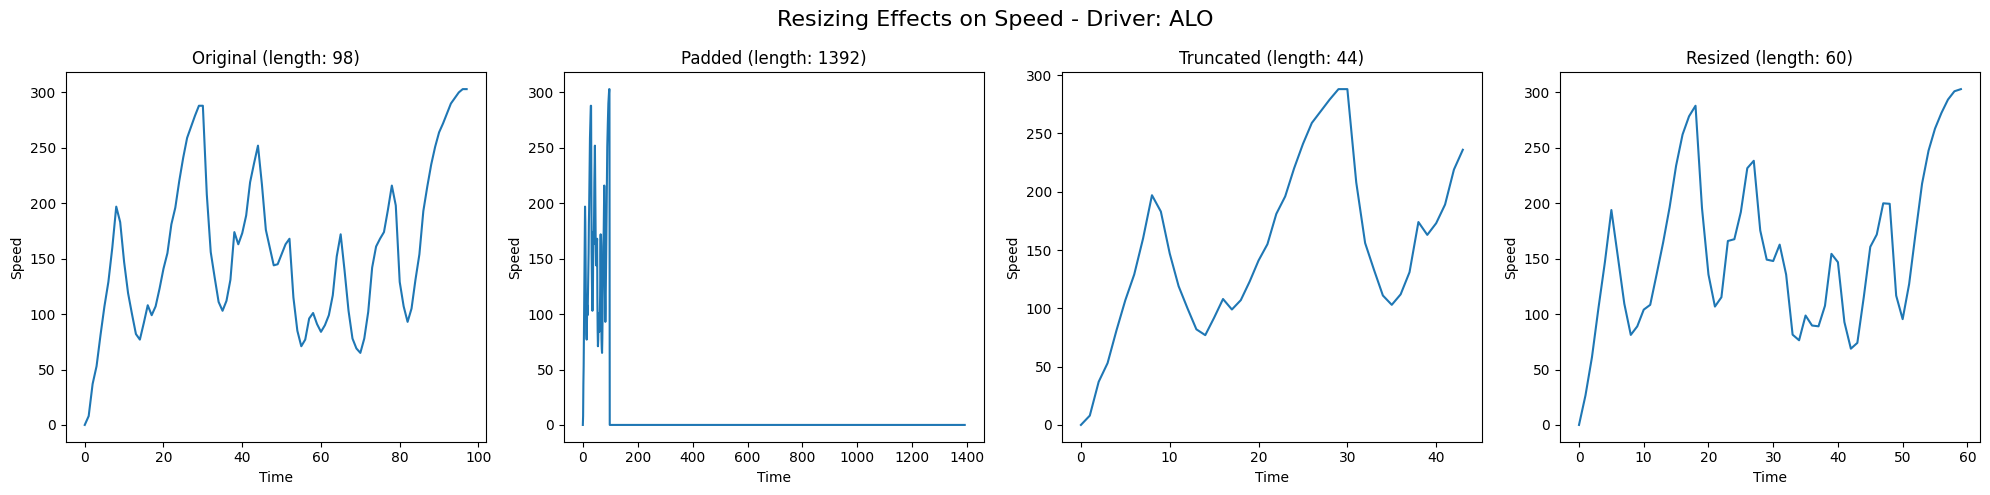

In [9]:
# Visualize the effects of different resizing methods
sample_idx = 0
feature_idx = 0  # Speed

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f'Resizing Effects on {final_features[feature_idx]} - Driver: {labels[sample_idx]}', fontsize=16)

# Original
axes[0].plot(time_series[sample_idx][feature_idx])
axes[0].set_title(f'Original (length: {time_series[sample_idx].shape[1]})')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Speed')

# Padded
axes[1].plot(time_series_padded[sample_idx, feature_idx])
axes[1].set_title(f'Padded (length: {time_series_padded.shape[2]})')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Speed')

# Truncated
axes[2].plot(time_series_truncated[sample_idx, feature_idx])
axes[2].set_title(f'Truncated (length: {time_series_truncated.shape[2]})')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Speed')

# Resized
axes[3].plot(time_series_resized[sample_idx, feature_idx])
axes[3].set_title(f'Resized (length: {target_length})')
axes[3].set_xlabel('Time')
axes[3].set_ylabel('Speed')

plt.tight_layout()
plt.show()

## 4. Apply Aeon Preprocessing - Scaling

Apply different scaling techniques to normalize the time series data.

In [10]:
# Use resized data for scaling (equal length, manageable size)
# Apply different scaling techniques

# 1. Normalization (zero mean, unit variance)
normalizer = Normalizer()
time_series_normalized = normalizer.fit_transform(time_series_resized)

# 2. Centering (zero mean)
centerer = Centerer()
time_series_centered = centerer.fit_transform(time_series_resized)

# 3. Min-Max scaling (0 to 1)
minmax_scaler = MinMaxScaler()
time_series_minmax = minmax_scaler.fit_transform(time_series_resized)

print("Scaling completed successfully!")
print(f"Original shape: {time_series_resized.shape}")
print(f"Normalized shape: {time_series_normalized.shape}")
print(f"Centered shape: {time_series_centered.shape}")
print(f"MinMax scaled shape: {time_series_minmax.shape}")

Scaling completed successfully!
Original shape: (1116, 9, 60)
Normalized shape: (1116, 9, 60)
Centered shape: (1116, 9, 60)
MinMax scaled shape: (1116, 9, 60)


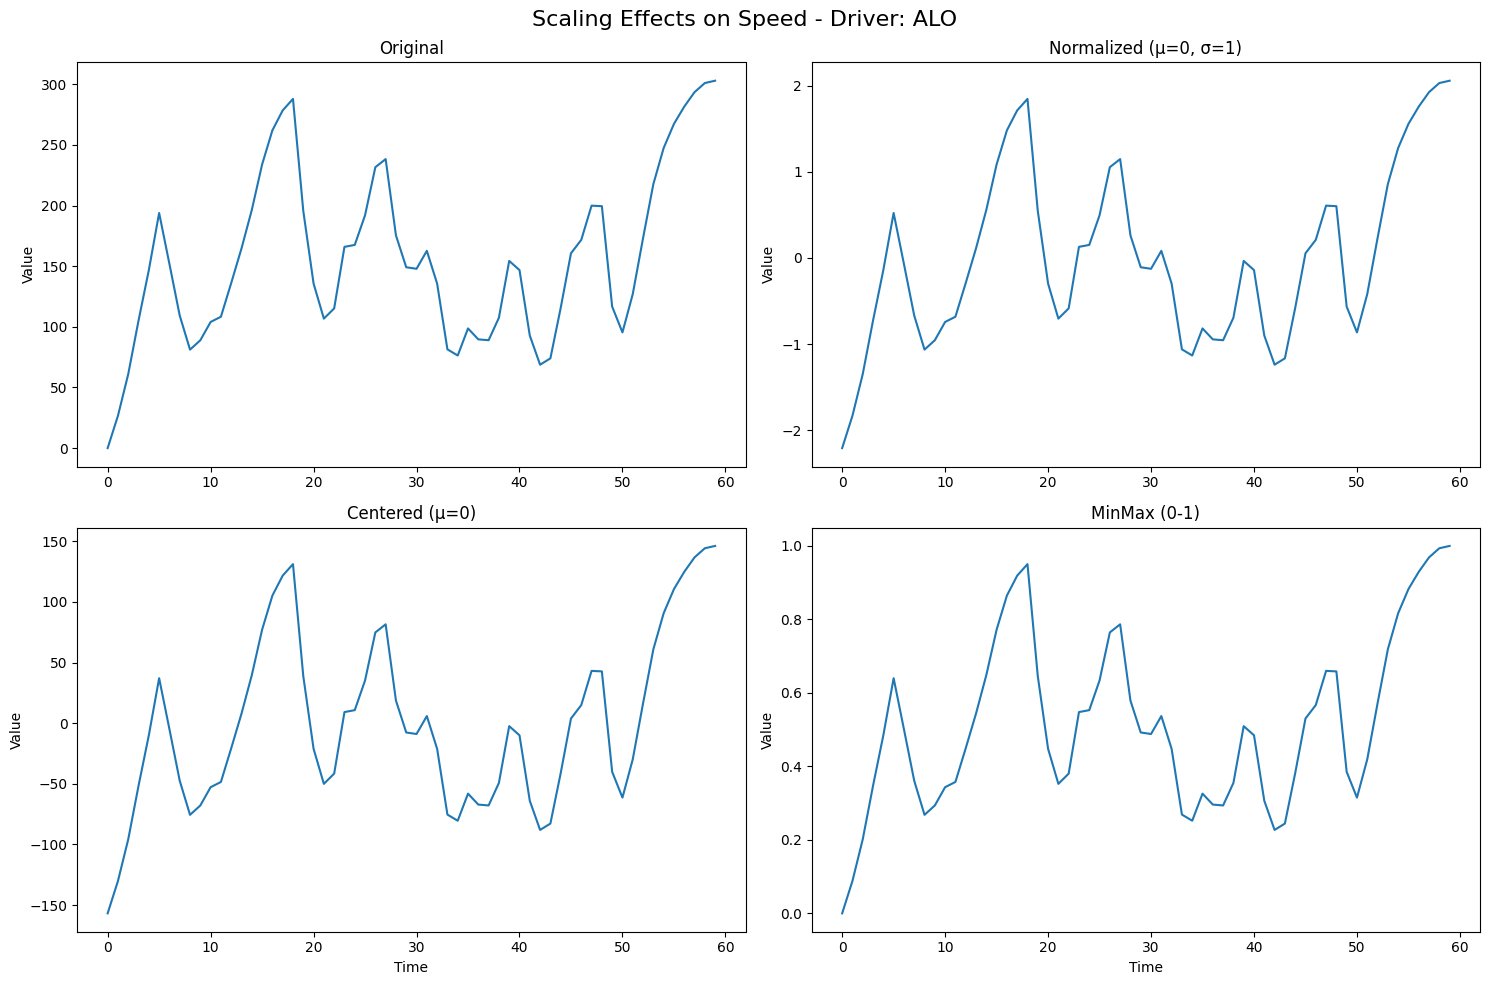

In [11]:
# Compare scaling effects on a sample time series
sample_idx = 0  # First time series
feature_idx = 0  # First feature (Speed)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Scaling Effects on {final_features[feature_idx]} - Driver: {labels[sample_idx]}', fontsize=16)

# Original data
axes[0, 0].plot(time_series_resized[sample_idx, feature_idx])
axes[0, 0].set_title('Original')
axes[0, 0].set_ylabel('Value')

# Normalized data
axes[0, 1].plot(time_series_normalized[sample_idx, feature_idx])
axes[0, 1].set_title('Normalized (μ=0, σ=1)')
axes[0, 1].set_ylabel('Value')

# Centered data
axes[1, 0].plot(time_series_centered[sample_idx, feature_idx])
axes[1, 0].set_title('Centered (μ=0)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')

# MinMax scaled data
axes[1, 1].plot(time_series_minmax[sample_idx, feature_idx])
axes[1, 1].set_title('MinMax (0-1)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

## 5. Handle Missing Values

Demonstrate how to handle missing values in time series data.

In [12]:
# Introduce some artificial missing values for demonstration
time_series_with_missing = time_series_resized.copy()

# Add some NaN values randomly
np.random.seed(42)
missing_indices = np.random.choice(
    time_series_with_missing.size, 
    size=int(0.01 * time_series_with_missing.size), 
    replace=False
)
time_series_with_missing.flat[missing_indices] = np.nan

print(f"Missing values introduced: {has_missing(time_series_with_missing)}")
print(f"Total missing values: {np.isnan(time_series_with_missing).sum()}")
print(f"Percentage missing: {np.isnan(time_series_with_missing).sum() / time_series_with_missing.size * 100:.2f}%")

Missing values introduced: True
Total missing values: 6026
Percentage missing: 1.00%


In [13]:
# Apply different imputation strategies

# 1. Mean imputation
mean_imputer = SimpleImputer(strategy="mean")
time_series_mean_imputed = mean_imputer.fit_transform(time_series_with_missing)

# 2. Median imputation
median_imputer = SimpleImputer(strategy="median")
time_series_median_imputed = median_imputer.fit_transform(time_series_with_missing)

# 3. Constant imputation
constant_imputer = SimpleImputer(strategy="constant", fill_value=0)
time_series_constant_imputed = constant_imputer.fit_transform(time_series_with_missing)

print("Imputation completed successfully!")
print(f"Mean imputed - Missing values: {has_missing(time_series_mean_imputed)}")
print(f"Median imputed - Missing values: {has_missing(time_series_median_imputed)}")
print(f"Constant imputed - Missing values: {has_missing(time_series_constant_imputed)}")

Imputation completed successfully!
Mean imputed - Missing values: False
Median imputed - Missing values: False
Constant imputed - Missing values: False


## 6. Combined Preprocessing Pipeline

Create a comprehensive preprocessing pipeline that combines multiple aeon transformations.

In [14]:
# Create a comprehensive preprocessing pipeline
preprocessing_pipeline = make_pipeline(
    Resizer(length=60),             # Standardize length to 60 time points
    SimpleImputer(strategy="mean"), # Handle missing values with mean imputation
    Normalizer()                    # Normalize to zero mean and unit variance
)

# Apply the pipeline to the original unequal length data
time_series_processed = preprocessing_pipeline.fit_transform(time_series)

print(f"Pipeline processing completed!")
print(f"Final shape: {time_series_processed.shape}")
print(f"Is equal length: {is_equal_length(time_series_processed)}")
print(f"Has missing values: {has_missing(time_series_processed)}")

Pipeline processing completed!
Final shape: (1116, 9, 60)
Is equal length: True
Has missing values: False


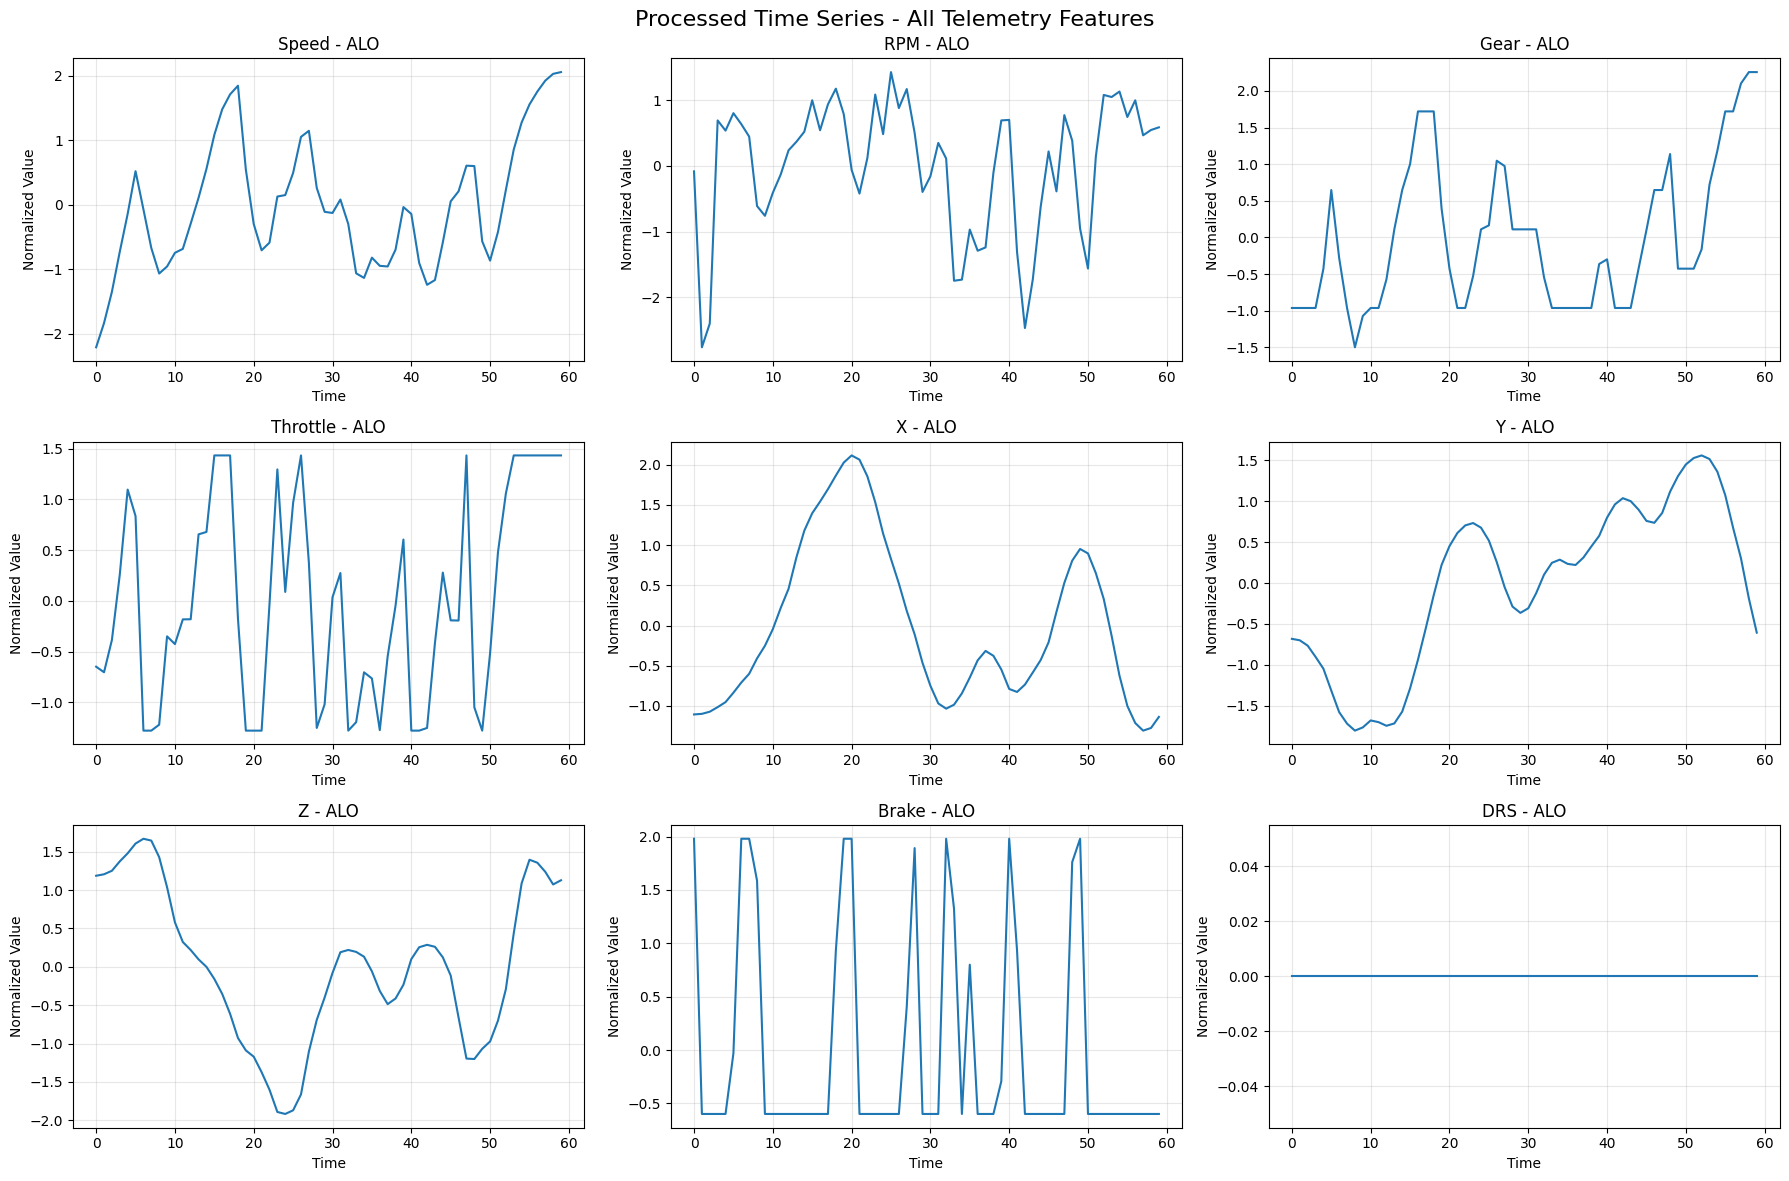

In [15]:
# Visualize the final processed data
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Processed Time Series - All Telemetry Features', fontsize=16)

sample_idx = 0  # First time series
driver_name = labels[sample_idx]

for i, feature_name in enumerate(final_features):
    row = i // 3
    col = i % 3
    
    axes[row, col].plot(time_series_processed[sample_idx, i])
    axes[row, col].set_title(f'{feature_name} - {driver_name}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Normalized Value')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Prepare Data for Machine Learning

Convert the processed data into formats suitable for different types of machine learning tasks.

In [16]:
# Create different target variables for different ML tasks

# 1. Driver classification (predict which driver based on telemetry)
y_driver = np.array(labels)

# 2. Tire compound classification (based on metadata)
y_compound = np.array([meta['compound'] for meta in metadata])

# 3. Track status classification
y_track_status = np.array([meta['track_status'] for meta in metadata])

print(f"Data shape: {time_series_processed.shape}")
print(f"Number of samples: {len(time_series_processed)}")
print(f"Number of features: {time_series_processed.shape[1]}")
print(f"Time series length: {time_series_processed.shape[2]}")
print(f"\nTarget variables:")
print(f"Unique drivers: {np.unique(y_driver)}")
print(f"Unique compounds: {np.unique(y_compound)}")
print(f"Unique track statuses: {np.unique(y_track_status)}")

Data shape: (1116, 9, 60)
Number of samples: 1116
Number of features: 9
Time series length: 60

Target variables:
Unique drivers: ['ALO' 'BEA' 'BOT' 'COL' 'GAS' 'HAM' 'HUL' 'LAW' 'LEC' 'NOR' 'OCO' 'PER'
 'PIA' 'RUS' 'SAI' 'TSU' 'VER' 'ZHO']
Unique compounds: ['INTERMEDIATE']
Unique track statuses: ['1' '2' '4' '5' '6']


In [17]:
# Create train/test splits
# Split data for driver classification
X_train, X_test, y_train, y_test = train_test_split(
    time_series_processed, y_driver, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_driver
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels: {len(y_train)}")
print(f"Test labels: {len(y_test)}")

Training set shape: (892, 9, 60)
Test set shape: (224, 9, 60)
Training labels: 892
Test labels: 224


## 8. Data Quality Assessment

Assess the quality of the preprocessed data.

In [18]:
# Statistical summary of processed data
print("Statistical Summary of Processed Time Series:")
print("=" * 50)

for i, feature_name in enumerate(final_features):
    feature_data = time_series_processed[:, i, :].flatten()
    print(f"\n{feature_name}:")
    print(f"  Mean: {np.mean(feature_data):.4f}")
    print(f"  Std:  {np.std(feature_data):.4f}")
    print(f"  Min:  {np.min(feature_data):.4f}")
    print(f"  Max:  {np.max(feature_data):.4f}")

Statistical Summary of Processed Time Series:

Speed:
  Mean: -0.0000
  Std:  1.0000
  Min:  -2.2429
  Max:  4.7828

RPM:
  Mean: -0.0000
  Std:  1.0000
  Min:  -3.2055
  Max:  3.4397

Gear:
  Mean: -0.0000
  Std:  1.0000
  Min:  -2.2576
  Max:  5.4433

Throttle:
  Mean: 0.0000
  Std:  1.0000
  Min:  -1.5850
  Max:  4.9941

X:
  Mean: -0.0000
  Std:  1.0000
  Min:  -1.6511
  Max:  5.8902

Y:
  Mean: -0.0000
  Std:  1.0000
  Min:  -2.1076
  Max:  5.4373

Z:
  Mean: -0.0000
  Std:  1.0000
  Min:  -6.0623
  Max:  1.9870

Brake:
  Mean: 0.0000
  Std:  1.0000
  Min:  -1.0617
  Max:  5.2803

DRS:
  Mean: -0.0000
  Std:  0.0599
  Min:  -0.1665
  Max:  7.6811


In [19]:
# Class distribution analysis
print("Class Distribution Analysis:")
print("=" * 30)

# Driver distribution
driver_counts = Counter(y_driver)
print(f"\nDriver distribution:")
for driver, count in sorted(driver_counts.items()):
    print(f"  {driver}: {count} samples ({count/len(y_driver)*100:.1f}%)")

# Compound distribution
compound_counts = Counter(y_compound)
print(f"\nTire compound distribution:")
for compound, count in sorted(compound_counts.items()):
    print(f"  {compound}: {count} samples ({count/len(y_compound)*100:.1f}%)")

Class Distribution Analysis:

Driver distribution:
  ALO: 69 samples (6.2%)
  BEA: 69 samples (6.2%)
  BOT: 69 samples (6.2%)
  COL: 30 samples (2.7%)
  GAS: 69 samples (6.2%)
  HAM: 69 samples (6.2%)
  HUL: 28 samples (2.5%)
  LAW: 65 samples (5.8%)
  LEC: 69 samples (6.2%)
  NOR: 69 samples (6.2%)
  OCO: 69 samples (6.2%)
  PER: 64 samples (5.7%)
  PIA: 69 samples (6.2%)
  RUS: 69 samples (6.2%)
  SAI: 39 samples (3.5%)
  TSU: 65 samples (5.8%)
  VER: 69 samples (6.2%)
  ZHO: 66 samples (5.9%)

Tire compound distribution:
  INTERMEDIATE: 1116 samples (100.0%)


## 9. Save Processed Data

Save the processed data for use in machine learning models.

In [20]:
# Save processed data
# Create a data dictionary
processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_driver_train': y_train,
    'y_driver_test': y_test,
    'y_compound': y_compound,
    'y_track_status': y_track_status,
    'feature_names': final_features,
    'metadata': metadata,
    'preprocessing_pipeline': preprocessing_pipeline
}

# Save to file
with open('f1_aeon_preprocessed_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("Processed data saved to 'f1_aeon_preprocessed_data.pkl'")
print(f"File contains {len(processed_data)} items:")
for key in processed_data.keys():
    print(f"  - {key}")

Processed data saved to 'f1_aeon_preprocessed_data.pkl'
File contains 9 items:
  - X_train
  - X_test
  - y_driver_train
  - y_driver_test
  - y_compound
  - y_track_status
  - feature_names
  - metadata
  - preprocessing_pipeline


## Summary

This notebook demonstrated how to:

1. **Load F1 Data**: Used FastF1 library and capstone package to process Formula 1 session data
2. **Create Time Series**: Converted F1 telemetry data into time series format suitable for aeon
3. **Handle Data Types**: Converted boolean features (Brake, DRS) to numeric for aeon compatibility
4. **Apply Resizing**: Used Padding, Truncation, and Resizing to standardize time series lengths
5. **Apply Scaling**: Used aeon's Normalizer, Centerer, and MinMaxScaler for data normalization
6. **Manage Missing Values**: Used SimpleImputer with different strategies (mean, median, constant)
7. **Create Pipelines**: Built comprehensive preprocessing pipelines combining multiple transformations
8. **Prepare for ML**: Created train/test splits and multiple target variables for different ML tasks
9. **Quality Assessment**: Analyzed statistical properties and class distributions
10. **Save Results**: Preserved processed data for future machine learning experiments

**Key Features:**
- **9 telemetry features**: Speed, RPM, Gear, Throttle, Brake (0/1), DRS (0/1), X, Y, Z coordinates
- **Multiple targets**: Driver classification, tire compound classification, track status classification
- **Standardized format**: All time series normalized to 60 time points with zero mean and unit variance
- **Ready for ML**: Compatible with aeon time series classifiers and other ML frameworks

The processed data is now ready for time series classification, clustering, or other machine learning tasks using aeon or other time series ML libraries.